## NBA Shot Chart

https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d


In [1]:
# Import packages
from nba_api.stats.endpoints import shotchartdetail
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Grab player ID number and team ID numbers

In [2]:
# Load teams file
teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)
# Load players file
players = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/players.json').text)

### ID helper functions

Create helper functions that take an input of a team name and a player’s name, and return their respective ID numbers. In both cases, if a player or team name cannot be found, the functions return -1


In [3]:
# Get team ID based on team name
def get_team_id(teamInput):
  for team in teams:
    if team['teamName'] == teamInput:
      return team['teamId']
  return -1
# Get player ID based on player name
def get_player_id(first, last):
  for player in players:
    if player['firstName'] == first and player['lastName'] == last:
      return player['playerId']
  return -1

### See functions in action

In [4]:
# Get the team ID number for the Knicks
teamID = get_team_id('Atlanta Hawks')
print(teamID)
# Get the player ID number for LeBron James
playerID = get_player_id('LeBron', 'James')
print(playerID)

1610612737
2544


### Collect shot data

documentation - https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md

For made shots change to: context_measure_simple = 'PTS',
   else FGA

To get regular season data, change:             
<dd>season_type_all_star = 'Regular Season')


In [5]:
# Create JSON request
shot_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id('Golden State Warriors'),
            player_id = get_player_id('Stephen', 'Curry'),
            context_measure_simple = 'PTS',
            season_nullable = '2021-22',
            season_type_all_star = 'Regular Season')

### Load JSON data into dictionary 

In [6]:
# Load data into a Python dictionary
shot_data = json.loads(shot_json.get_json())

### Grab relevant data
Our relevant data can be found under the resultSets key, which is an array in itself — we need the first element of this array.

In [7]:
# Get the relevant data from our dictionary
relevant_data = shot_data['resultSets'][0]

### Put the data into a pandas dataframe

In [8]:
# Get the headers and row data
headers = relevant_data['headers']
rows = relevant_data['rowSet']

# Create pandas DataFrame
playerShotData = pd.DataFrame(rows)
playerShotData.columns = headers

# What do we have? 
playerShotData.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

### Create function to draw the court

In [9]:
# Function to draw basketball court
def create_court(ax, color):
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

### Create short chart 

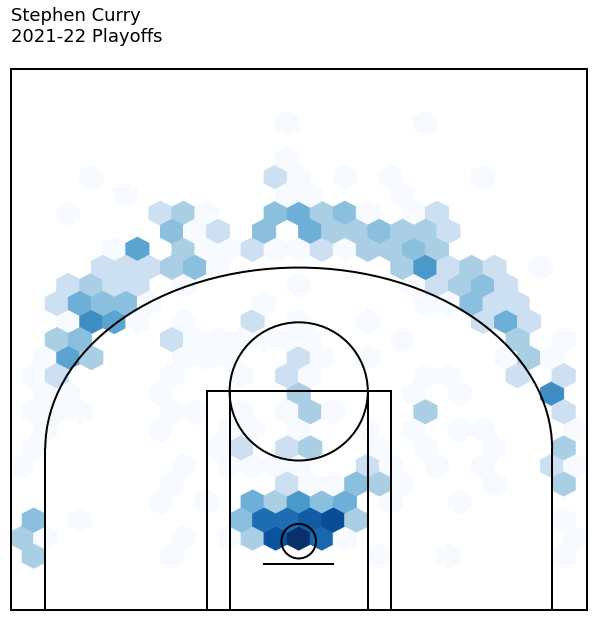

In [12]:
# General plot parameters
#mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2

import numpy as np 

from matplotlib.colors import LinearSegmentedColormap

# Colormap documentation: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Color picker: https://www.rapidtables.com/web/color/RGB_Color.html

# colors = [(0.6, 0.76, 0.98), (0, 0.21, 0.46)] # Experiment with this
colors = [(10/255, 90/255, 170/255), (1, 0, 0)] # Experiment with this
cm = LinearSegmentedColormap.from_list('test', colors, N=10)

# Draw basketball court
#fig = plt.figure(figsize=(4, 3.76))
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])
# Plot hexbin of shots with logarithmic binning
# A list of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.hexbin(playerShotData['LOC_X'], playerShotData['LOC_Y'] + 60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Blues')

ax = create_court(ax, 'black')
# Annotate player name and season
fig.text(0, 1.05, 'Stephen Curry\n2021-22 Playoffs', ha='left', va='baseline')

plt.savefig('shotchart.png',dpi=400,pad_inches=0,bbox_inches='tight')

plt.show()

### Output data to CSV file

In [11]:
playerShotData.to_csv('shotdata.csv')